# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/adebraine/Documents/Personal Projects/RL - Udacity/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Building the Network Architecture
Importing the Deep Q-Network Agent and building the architecture based on specific hyperparameters

- 3 hidden layers:
    - (Number of States=37, 512)
    - (512, 256)
    - (256, 128)
    - (128, Number of Actions=4)
- A batch size of 32
- A learning rate of 0.0005

In [5]:
# Watch changes and reload automatically
%load_ext autoreload
%autoreload 2
from train import train
from dqn_agent import DQN_Agent

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = DQN_Agent(state_size=state_size,
                  action_size=action_size,
                  hidden_layers=[512,256,128],
                  buffer_size=int(1e5),
                  batch_size=32,
                  gamma=0.99,
                  tau=1e-3,
                  lr=5e-4,
                  update_every=4,
                  drop_p=0.0,
                  device=device,
                  seed=0)

cuda:0


### Training the Model
Training the agent based on the following hyperparameters:
- $\epsilon$ decay rate of 0.95
    - Tested multiple values (0.995, 0.999, 0.99, 0.95). Iterating through these values improved the training speed the most.

In [7]:
scores = train(agent=agent,
               env=env,
               n_episodes=2000,
               max_t=1000,
               eps_start=1.0,
               eps_end=0.005,
               eps_decay=0.95)

Episode 100	Average Score: 6.11
Episode 200	Average Score: 11.08
Episode 300	Average Score: 11.69
Episode 371	Average Score: 13.08
Environment solved in 271 episodes!	Average Score: 13.08


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_scores(scores, order):
    plt.plot(np.arange(len(scores)), scores)
    sns.regplot(x=np.arange(len(scores)), y=scores, order=order, scatter=False)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Score')
    plt.show()

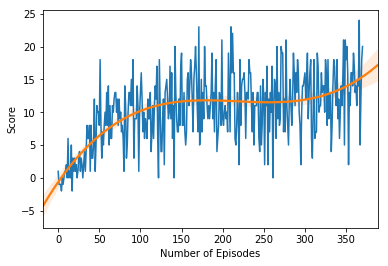

In [19]:
plot_scores(scores, order=3)

### Loading a Pre-Trained Model for Demonstration
Loading a pre-trained model and displaying its performance in the virtual environment until a specific score is reached in order to visualize multiple behaviors.

In [7]:
agent.qnetwork_local.load_state_dict(torch.load('Solved_ep271.pth'))

In [13]:
while score < 15:
    display=True
    if display:
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        while True:
            action = agent.act(state)                      # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        print("Score: {}".format(score))

Score: 14.0
Score: 14.0
Score: 4.0
Score: 0.0
Score: 4.0
Score: 1.0
Score: 14.0
Score: 17.0


When finished, you can close the environment.

In [14]:
env.close()